# Sarsa
- 価値反復法のアルゴリズムの一つ。
- 行動価値を行が状態s、列が行動aとして定義する。
- 各時刻での行動aを行動価値関数Qから求める方策を実装する。（Qの値が最大となる行動を採用する）
- ただし、正しいQが定まっていない状態でこの方策を採用すると初期値に応じて行動が確定してしまうため、
- 一定の確率εでランダムに行動する作戦をとる。（ε-greedy法）

In [11]:
# 使用するパッケージの宣言
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

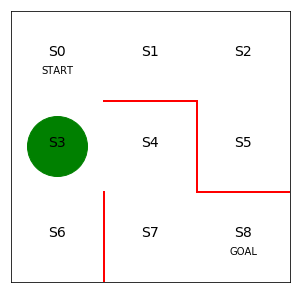

In [12]:
# 初期位置での迷路の様子

# 図を描く大きさと、図の変数名を宣言
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()

# 赤い壁を描く
plt.plot([1, 1], [0, 1], color='red', linewidth=2)
plt.plot([1, 2], [2, 2], color='red', linewidth=2)
plt.plot([2, 2], [2, 1], color='red', linewidth=2)
plt.plot([2, 3], [1, 1], color='red', linewidth=2)

# 状態を示す文字S0～S8を描く
plt.text(0.5, 2.5, 'S0', size=14, ha='center')
plt.text(1.5, 2.5, 'S1', size=14, ha='center')
plt.text(2.5, 2.5, 'S2', size=14, ha='center')
plt.text(0.5, 1.5, 'S3', size=14, ha='center')
plt.text(1.5, 1.5, 'S4', size=14, ha='center')
plt.text(2.5, 1.5, 'S5', size=14, ha='center')
plt.text(0.5, 0.5, 'S6', size=14, ha='center')
plt.text(1.5, 0.5, 'S7', size=14, ha='center')
plt.text(2.5, 0.5, 'S8', size=14, ha='center')
plt.text(0.5, 2.3, 'START', ha='center')
plt.text(2.5, 0.3, 'GOAL', ha='center')

# 描画範囲の設定と目盛りを消す設定
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='off', right='off', left='off', labelleft='off')

# 現在地S0に緑丸を描画する
line, = ax.plot([0.5], [1.5], marker="o", color='g', markersize=60)

In [13]:
# 初期の方策を決定するパラメータtheta_0を設定
# 方策　エージェントがどのように行動するかを決めたルール
# pi_theta(s, a)
# 状態sの時に行動aを採用する確率はパラメータthetaで決まる方策piに従う。

# 表形式表現　行が状態、列が行動aを示し、値はその行動を採用する確率
# 行は状態0～7、列は移動方向で↑、→、↓、←を表す
# columns ========> [up    . right , down  , left  ]
theta_0 = np.array([[np.nan, 1     , 1     , np.nan],  # s0
                    [np.nan, 1     , np.nan, 1     ],  # s1
                    [np.nan, np.nan, 1     , 1     ],  # s2
                    [1     , 1     , 1     , np.nan],  # s3
                    [np.nan, np.nan, 1     , 1     ],  # s4
                    [1     , np.nan, np.nan, np.nan],  # s5
                    [1     , np.nan, np.nan, np.nan],  # s6
                    [1     , 1     , np.nan, np.nan],  # s7、※s8はゴールなので、方策はなし
                    ])

In [14]:
# 方策パラメータtheta_0をランダム方策piに変換する関数の定義


def simple_convert_into_pi_from_theta(theta):
    '''単純に割合を計算する'''

    m, n = theta.shape  # thetaの行列サイズを取得
    pi = np.zeros((m, n))
    for i in range(0, m):
        pi[i, :] = theta[i, :] / np.nansum(theta[i, :])  # 割合の計算

    pi = np.nan_to_num(pi)  # nanを0に変換

    return pi

# ランダム行動方策pi_0を求める
pi_0 = simple_convert_into_pi_from_theta(theta_0)
pi_0

array([[0.        , 0.5       , 0.5       , 0.        ],
       [0.        , 0.5       , 0.        , 0.5       ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [0.33333333, 0.33333333, 0.33333333, 0.        ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [1.        , 0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        ],
       [0.5       , 0.5       , 0.        , 0.        ]])

In [15]:
# 初期の行動価値関数Qを設定

a, b = theta_0.shape  # 行と列の数をa, bに格納
Q = np.random.rand(a, b) * theta_0
# * theta0をすることで要素ごとに掛け算をし、Qの壁方向の値がnanになる
Q

array([[       nan, 0.84245953, 0.82404084,        nan],
       [       nan, 0.34398375,        nan, 0.57268604],
       [       nan,        nan, 0.11580861, 0.8495932 ],
       [0.30770528, 0.47748067, 0.18993592,        nan],
       [       nan,        nan, 0.94699215, 0.34739532],
       [0.62020382,        nan,        nan,        nan],
       [0.14284934,        nan,        nan,        nan],
       [0.788354  , 0.08826509,        nan,        nan]])

In [16]:
# ε-greedy法を実装


def get_action(s, Q, epsilon, pi_0):
    direction = ["up", "right", "down", "left"]

    # 行動を決める
    if np.random.rand() < epsilon:
        # εの確率でランダムに動く
        next_direction = np.random.choice(direction, p=pi_0[s, :])
    else:
        # Qの最大値の行動を採用する
        next_direction = direction[np.nanargmax(Q[s, :])]

    # 行動をindexに
    if next_direction == "up":
        action = 0
    elif next_direction == "right":
        action = 1
    elif next_direction == "down":
        action = 2
    elif next_direction == "left":
        action = 3

    return action


def get_s_next(s, a, Q, epsilon, pi_0):
    direction = ["up", "right", "down", "left"]
    next_direction = direction[a]  # 行動aの方向

    # 行動から次の状態を決める
    if next_direction == "up":
        s_next = s - 3  # 上に移動するときは状態の数字が3小さくなる
    elif next_direction == "right":
        s_next = s + 1  # 右に移動するときは状態の数字が1大きくなる
    elif next_direction == "down":
        s_next = s + 3  # 下に移動するときは状態の数字が3大きくなる
    elif next_direction == "left":
        s_next = s - 1  # 左に移動するときは状態の数字が1小さくなる

    return s_next

In [17]:
# Sarsaによる行動価値関数Qの更新


def Sarsa(s, a, r, s_next, a_next, Q, eta, gamma):

    if s_next == 8:  # ゴールした場合
        Q[s, a] = Q[s, a] + eta * (r - Q[s, a])

    else:
        Q[s, a] = Q[s, a] + eta * (r + gamma * Q[s_next, a_next] - Q[s, a])

    return Q

In [18]:
# Sarsaで迷路を解く関数の定義、状態と行動の履歴および更新したQを出力


def goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi):
    s = 0  # スタート地点
    a = a_next = get_action(s, Q, epsilon, pi)  # 初期の行動
    s_a_history = [[0, np.nan]]  # エージェントの移動を記録するリスト

    while True:  # ゴールするまでループ
        a = a_next  # 行動更新

        s_a_history[-1][1] = a
        # 現在の状態（つまり一番最後なのでindex=-1）に行動を代入

        s_next = get_s_next(s, a, Q, epsilon, pi)
        # 次の状態を格納

        s_a_history.append([s_next, np.nan])
        # 次の状態を代入。行動はまだ分からないのでnanにしておく

        # 報酬を与え,　次の行動を求めます
        if s_next == 8:
            r = 1  # ゴールにたどり着いたなら報酬を与える
            a_next = np.nan
        else:
            r = 0
            a_next = get_action(s_next, Q, epsilon, pi)
            # 次の行動a_nextを求めます。

        # 価値関数を更新
        Q = Sarsa(s, a, r, s_next, a_next, Q, eta, gamma)
        print("updated Q")
        print(Q)

        # 終了判定
        if s_next == 8:  # ゴール地点なら終了
            break
        else:
            s = s_next

    return s_a_history, Q

In [19]:
# Sarsaで迷路を解く

eta = 0.1  # 学習率
gamma = 0.9  # 時間割引率
epsilon = 0.5  # ε-greedy法の初期値
v = np.nanmax(Q, axis=1)  # 状態ごとに価値の最大値を求める
is_continue = True
episode = 1

while is_continue:  # is_continueがFalseになるまで繰り返す
    print("エピソード:" + str(episode))

    # ε-greedyの値を少しずつ小さくする
    epsilon = epsilon / 2

    # Sarsaで迷路を解き、移動した履歴と更新したQを求める
    s_a_history, Q = goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi_0)

    # 状態価値の変化
    new_v = np.nanmax(Q, axis=1)  # 状態ごとに価値の最大値を求める
    print(np.sum(np.abs(new_v - v)))  # 状態価値の変化を出力
    v = new_v

    print("迷路を解くのにかかったステップ数は" + str(len(s_a_history) - 1) + "です")

    # 100エピソード繰り返す
    episode = episode + 1
    if episode > 100:
        break

エピソード:1
updated Q
[[       nan 0.80975532 0.82404084        nan]
 [       nan 0.34398375        nan 0.57268604]
 [       nan        nan 0.11580861 0.8495932 ]
 [0.30770528 0.47748067 0.18993592        nan]
 [       nan        nan 0.94699215 0.34739532]
 [0.62020382        nan        nan        nan]
 [0.14284934        nan        nan        nan]
 [0.788354   0.08826509        nan        nan]]
updated Q
[[       nan 0.80975532 0.82404084        nan]
 [       nan 0.34398375        nan 0.58958111]
 [       nan        nan 0.11580861 0.8495932 ]
 [0.30770528 0.47748067 0.18993592        nan]
 [       nan        nan 0.94699215 0.34739532]
 [0.62020382        nan        nan        nan]
 [0.14284934        nan        nan        nan]
 [0.788354   0.08826509        nan        nan]]
updated Q
[[       nan 0.80975532 0.78461002        nan]
 [       nan 0.34398375        nan 0.58958111]
 [       nan        nan 0.11580861 0.8495932 ]
 [0.30770528 0.47748067 0.18993592        nan]
 [       nan        

 [0.5813662  0.17943858        nan        nan]]
updated Q
[[       nan 0.80975532 0.75249559        nan]
 [       nan 0.34398375        nan 0.58958111]
 [       nan        nan 0.11580861 0.8495932 ]
 [0.30770528 0.54803289 0.18993592        nan]
 [       nan        nan 0.65180955 0.4080528 ]
 [0.62020382        nan        nan        nan]
 [0.14284934        nan        nan        nan]
 [0.55995433 0.17943858        nan        nan]]
updated Q
[[       nan 0.80975532 0.75249559        nan]
 [       nan 0.34398375        nan 0.58958111]
 [       nan        nan 0.11580861 0.8495932 ]
 [0.30770528 0.54803289 0.18993592        nan]
 [       nan        nan 0.65180955 0.41657048]
 [0.62020382        nan        nan        nan]
 [0.14284934        nan        nan        nan]
 [0.55995433 0.17943858        nan        nan]]
updated Q
[[       nan 0.80975532 0.75249559        nan]
 [       nan 0.34398375        nan 0.58958111]
 [       nan        nan 0.11580861 0.8495932 ]
 [0.30770528 0.55189246 0.1

 [0.54423654 0.26149472        nan        nan]]
updated Q
[[       nan 0.73679002 0.72691635        nan]
 [       nan 0.34398375        nan 0.61590302]
 [       nan        nan 0.11580861 0.8495932 ]
 [0.30770528 0.54975565 0.18993592        nan]
 [       nan        nan 0.55156948 0.41657048]
 [0.62020382        nan        nan        nan]
 [0.14284934        nan        nan        nan]
 [0.53945414 0.26149472        nan        nan]]
updated Q
[[       nan 0.73679002 0.72691635        nan]
 [       nan 0.34398375        nan 0.61590302]
 [       nan        nan 0.11580861 0.8495932 ]
 [0.30770528 0.54975565 0.18993592        nan]
 [       nan        nan 0.54496341 0.41657048]
 [0.62020382        nan        nan        nan]
 [0.14284934        nan        nan        nan]
 [0.53945414 0.26149472        nan        nan]]
updated Q
[[       nan 0.73679002 0.72691635        nan]
 [       nan 0.34398375        nan 0.61590302]
 [       nan        nan 0.11580861 0.8495932 ]
 [0.30770528 0.54975565 0.1

 [0.3414445  0.33534525        nan        nan]]
updated Q
[[       nan 0.54321836 0.53914093        nan]
 [       nan 0.34398375        nan 0.53913731]
 [       nan        nan 0.11580861 0.8495932 ]
 [0.43773399 0.34213585 0.18993592        nan]
 [       nan        nan 0.34112848 0.33937346]
 [0.62020382        nan        nan        nan]
 [0.14284934        nan        nan        nan]
 [0.3414445  0.33534525        nan        nan]]
updated Q
[[       nan 0.53741889 0.53914093        nan]
 [       nan 0.34398375        nan 0.53913731]
 [       nan        nan 0.11580861 0.8495932 ]
 [0.43773399 0.34213585 0.18993592        nan]
 [       nan        nan 0.34112848 0.33937346]
 [0.62020382        nan        nan        nan]
 [0.14284934        nan        nan        nan]
 [0.3414445  0.33534525        nan        nan]]
updated Q
[[       nan 0.53741889 0.53914093        nan]
 [       nan 0.34398375        nan 0.53374626]
 [       nan        nan 0.11580861 0.8495932 ]
 [0.43773399 0.34213585 0.1

 [0.3414445  0.33534525        nan        nan]]
updated Q
[[       nan 0.34019784 0.34148031        nan]
 [       nan 0.41145902        nan 0.34252347]
 [       nan        nan 0.11580861 0.72157044]
 [0.34072312 0.34213585 0.18993592        nan]
 [       nan        nan 0.34112848 0.33937346]
 [0.62020382        nan        nan        nan]
 [0.14284934        nan        nan        nan]
 [0.3414445  0.33534525        nan        nan]]
updated Q
[[       nan 0.34019784 0.34148031        nan]
 [       nan 0.41145902        nan 0.34252347]
 [       nan        nan 0.1600461  0.72157044]
 [0.34072312 0.34213585 0.18993592        nan]
 [       nan        nan 0.34112848 0.33937346]
 [0.62020382        nan        nan        nan]
 [0.14284934        nan        nan        nan]
 [0.3414445  0.33534525        nan        nan]]
updated Q
[[       nan 0.34019784 0.34148031        nan]
 [       nan 0.41145902        nan 0.34252347]
 [       nan        nan 0.1600461  0.72157044]
 [0.34072312 0.34213585 0.1

[[       nan 0.34019784 0.34148031        nan]
 [       nan 0.42961914        nan 0.34252347]
 [       nan        nan 0.23590273 0.45890212]
 [0.34072312 0.34213585 0.18993592        nan]
 [       nan        nan 0.34112848 0.33937346]
 [0.61438126        nan        nan        nan]
 [0.14284934        nan        nan        nan]
 [0.3414445  0.33534525        nan        nan]]
updated Q
[[       nan 0.34019784 0.34148031        nan]
 [       nan 0.42961914        nan 0.34252347]
 [       nan        nan 0.23590273 0.45167763]
 [0.34072312 0.34213585 0.18993592        nan]
 [       nan        nan 0.34112848 0.33937346]
 [0.61438126        nan        nan        nan]
 [0.14284934        nan        nan        nan]
 [0.3414445  0.33534525        nan        nan]]
updated Q
[[       nan 0.34019784 0.34148031        nan]
 [       nan 0.42730821        nan 0.34252347]
 [       nan        nan 0.23590273 0.45167763]
 [0.34072312 0.34213585 0.18993592        nan]
 [       nan        nan 0.34112848 0.3

 [0.33430841 0.56392002        nan        nan]]
updated Q
[[       nan 0.31041445 0.3118967         nan]
 [       nan 0.30987489        nan 0.31252782]
 [       nan        nan 0.23590273 0.31253933]
 [0.31865452 0.32150401 0.18993592        nan]
 [       nan        nan 0.35446276 0.32927572]
 [0.61438126        nan        nan        nan]
 [0.14284934        nan        nan        nan]
 [0.33430841 0.56392002        nan        nan]]
updated Q
[[       nan 0.31041445 0.3118967         nan]
 [       nan 0.30987489        nan 0.31252782]
 [       nan        nan 0.23590273 0.3094129 ]
 [0.31865452 0.32150401 0.18993592        nan]
 [       nan        nan 0.35446276 0.32927572]
 [0.61438126        nan        nan        nan]
 [0.14284934        nan        nan        nan]
 [0.33430841 0.56392002        nan        nan]]
updated Q
[[       nan 0.31041445 0.3118967         nan]
 [       nan 0.30987489        nan 0.30934574]
 [       nan        nan 0.23590273 0.3094129 ]
 [0.31865452 0.32150401 0.1

 [0.33430841 0.96869391        nan        nan]]
0.03574142773487027
迷路を解くのにかかったステップ数は4です
エピソード:33
updated Q
[[       nan 0.30105415 0.4321781         nan]
 [       nan 0.30055852        nan 0.30019185]
 [       nan        nan 0.23590273 0.30020788]
 [0.31865452 0.58310267 0.18993592        nan]
 [       nan        nan 0.78257076 0.32927572]
 [0.61438126        nan        nan        nan]
 [0.14284934        nan        nan        nan]
 [0.33430841 0.96869391        nan        nan]]
updated Q
[[       nan 0.30105415 0.4321781         nan]
 [       nan 0.30055852        nan 0.30019185]
 [       nan        nan 0.23590273 0.30020788]
 [0.31865452 0.59522377 0.18993592        nan]
 [       nan        nan 0.78257076 0.32927572]
 [0.61438126        nan        nan        nan]
 [0.14284934        nan        nan        nan]
 [0.33430841 0.96869391        nan        nan]]
updated Q
[[       nan 0.30105415 0.4321781         nan]
 [       nan 0.30055852        nan 0.30019185]
 [       nan        nan 

[[       nan 0.30105415 0.70510883        nan]
 [       nan 0.30055852        nan 0.30019185]
 [       nan        nan 0.23590273 0.30020788]
 [0.31865452 0.80070246 0.18993592        nan]
 [       nan        nan 0.89774551 0.32927572]
 [0.61438126        nan        nan        nan]
 [0.14284934        nan        nan        nan]
 [0.33430841 0.99972676        nan        nan]]
updated Q
[[       nan 0.30105415 0.70510883        nan]
 [       nan 0.30055852        nan 0.30019185]
 [       nan        nan 0.23590273 0.30020788]
 [0.31865452 0.80142931 0.18993592        nan]
 [       nan        nan 0.89774551 0.32927572]
 [0.61438126        nan        nan        nan]
 [0.14284934        nan        nan        nan]
 [0.33430841 0.99972676        nan        nan]]
updated Q
[[       nan 0.30105415 0.70510883        nan]
 [       nan 0.30055852        nan 0.30019185]
 [       nan        nan 0.23590273 0.30020788]
 [0.31865452 0.80142931 0.18993592        nan]
 [       nan        nan 0.89794637 0.3

In [20]:
v

array([0.72428597, 0.30055852, 0.30020788, 0.80865512, 0.89974449,
       0.61438126, 0.14284934, 0.99997578])